(bivariate-growth-mod-notebook)=
# Modelli di crescita latenti bivariati

I ricercatori frequentemente indagano lo sviluppo di più costrutti nel tempo per comprendere come questi si sviluppino insieme e come interagiscano tra loro. Esistono vari modelli statistici per esaminare contemporaneamente il cambiamento in più variabili. In questo capitolo, ci focalizziamo su due modelli specifici: 

1. **Modello di Crescita Multivariato (MGM):** Questo modello è utilizzato per esplorare le interrelazioni tra due o più processi di crescita distinti. Attraverso il MGM, possiamo esaminare come diversi costrutti si sviluppino parallelamente e in che modo le loro traiettorie di crescita siano interconnesse. Ad esempio, il modello può essere impiegato per studiare come le capacità linguistiche e matematiche di un bambino si evolvano insieme nel corso del tempo.

2. **Modello di Crescita con Covariata Variabile nel Tempo (TVC):** Questo modello stima l'effetto di una variabile che cambia nel tempo (ad esempio, l'esposizione a un particolare ambiente educativo) sui punteggi di un costrutto, mentre modella contemporaneamente il cambiamento in questi punteggi. Il modello TVC permette di analizzare come i cambiamenti in una variabile (la covariata) influenzino la traiettoria di crescita di un'altra variabile.

Entrambi questi modelli sono ampiamente utilizzati nella ricerca sullo sviluppo. Sono particolarmente preziosi per rispondere a domande specifiche sulle relazioni tra variabili che cambiano simultaneamente e sui cambiamenti correlati tra individui. 

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
})

Questo tutorial mostra come adattare modelli di crescita lineare multivariati (bivariati) nel framework SEM in R. I dati sono tratti dal Capitolo 8 {cite:t}`grimm2016growth`. In particolare, utilizzando il set di dati NLSY-CYA, esaminiamo come le differenze individuali nella variazione del rendimento in matematica dei bambini (`math2`, ... `math8`) siano correlate alle differenze individuali nella variazione dell'iperattività dei bambini valutata dagli insegnanti (`hyp2`, ..., `hyp8`). 

In [2]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_hyp_long_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_hyp_long <- dat

# Add names the columns of the data set
names(nlsy_math_hyp_long) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math", "comp", "rec", "bpi", "as", "anx", "hd",
  "hyp", "dp", "wd",
  "grade", "occ", "age", "men", "spring", "anti"
)

# reducing to variables of interest
nlsy_math_hyp_long <- nlsy_math_hyp_long[, c("id", "grade", "math", "hyp")]

# view the first few observations in the data set
head(nlsy_math_hyp_long, 10)

,id,grade,math,hyp
,<int>,<int>,<int>,<int>
1,201,3,38,0
2,201,5,55,0
3,303,2,26,1
4,303,5,33,1
5,2702,2,56,2
6,2702,4,58,3
7,2702,8,80,3
8,4303,3,41,1
9,4303,4,58,1


Il nostro interesse specifico è il cambiamento intra-individuale nelle misure ripetute di matematica e iperattività durante il periodo scolastico (`grade`).

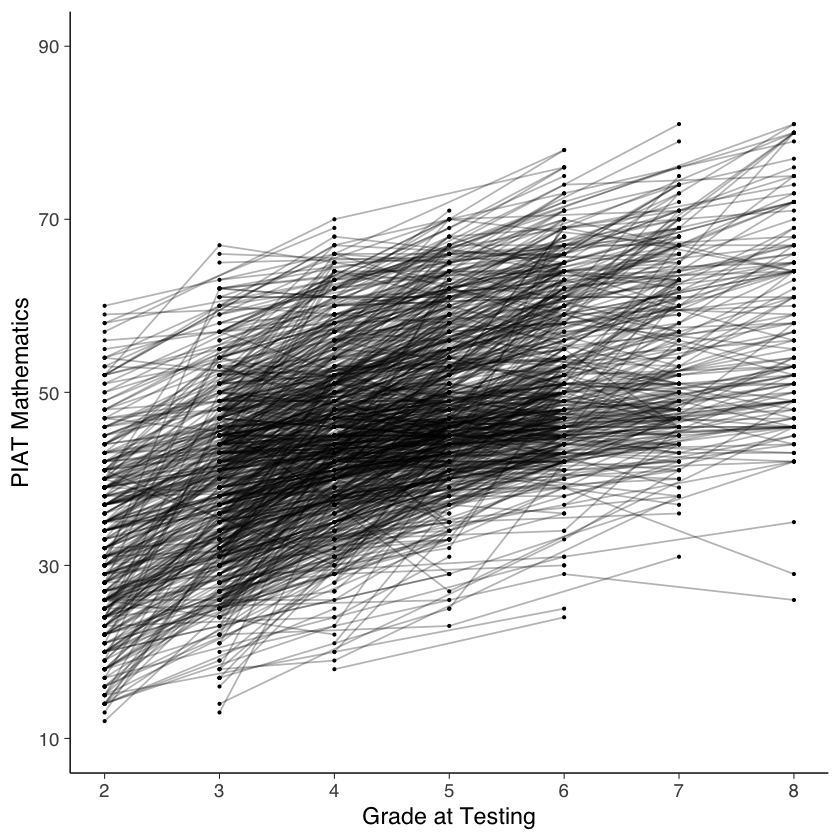

In [3]:
# intraindividual change trajetories
ggplot(
  data = nlsy_math_hyp_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line(alpha=0.3) + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )

Esaminiamo i punteggi di iperattività in funzione di `grade`.

Warning message:
“Removed 51 rows containing missing values or values outside the scale range (`geom_point()`).”


Warning message:
“Removed 44 rows containing missing values or values outside the scale range (`geom_line()`).”


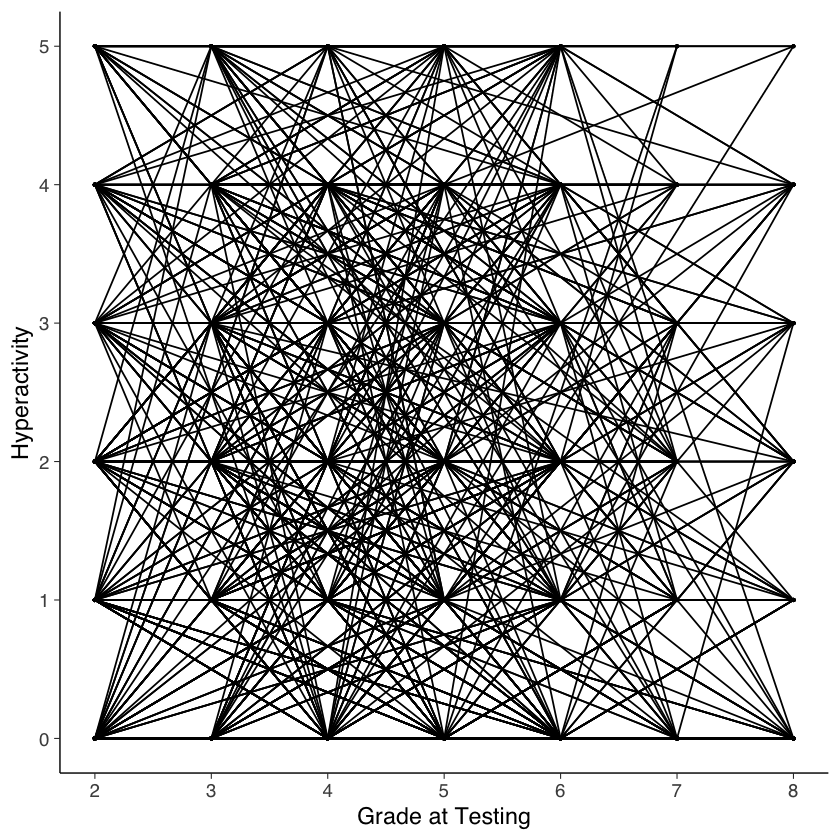

In [4]:
# intraindividual change trajetories
ggplot(
  data = nlsy_math_hyp_long, # data set
  aes(x = grade, y = hyp, group = id)
) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line() + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(0, 5),
    breaks = c(0, 1, 2, 3, 4, 5),
    name = "Hyperactivity"
  )

Per semplicità, leggiamo i dati in formato long da file.

In [5]:
# set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_hyp_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_hyp_wide <- dat

# Add names the columns of the data set
# Give the variable names
names(nlsy_math_hyp_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "comp2", "comp3", "comp4", "comp5", "comp6", "comp7", "comp8",
  "rec2", "rec3", "rec4", "rec5", "rec6", "rec7", "rec8",
  "bpi2", "bpi3", "bpi4", "bpi5", "bpi6", "bpi7", "bpi8",
  "asl2", "asl3", "asl4", "asl5", "asl6", "asl7", "asl8",
  "ax2", "ax3", "ax4", "ax5", "ax6", "ax7", "ax8",
  "hds2", "hds3", "hds4", "hds5", "hds6", "hds7", "hds8",
  "hyp2", "hyp3", "hyp4", "hyp5", "hyp6", "hyp7", "hyp8",
  "dpn2", "dpn3", "dpn4", "dpn5", "dpn6", "dpn7", "dpn8",
  "wdn2", "wdn3", "wdn4", "wdn5", "wdn6", "wdn7", "wdn8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# reducing to variables of interest
nlsy_multi_wide <- nlsy_math_hyp_wide[, c(
  "id",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "hyp2", "hyp3", "hyp4", "hyp5", "hyp6", "hyp7", "hyp8"
)]

# view the first few observations in the data set
head(nlsy_multi_wide, 10)

,id,math2,math3,math4,math5,math6,math7,math8,hyp2,hyp3,hyp4,hyp5,hyp6,hyp7,hyp8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,38,NA,55,NA,NA,NA,NA,0,NA,0,NA,NA,NA
2,303,26,NA,NA,33,NA,NA,NA,1,NA,NA,1,NA,NA,NA
3,2702,56,NA,58,NA,NA,NA,80,2,NA,3,NA,NA,NA,3
4,4303,NA,41,58,NA,NA,NA,NA,NA,1,1,NA,NA,NA,NA
5,5002,NA,NA,46,NA,54,NA,66,NA,NA,3,NA,2,NA,3
6,5005,35,NA,50,NA,60,NA,59,0,NA,3,NA,0,NA,1
7,5701,NA,62,61,NA,NA,NA,NA,NA,4,3,NA,NA,NA,NA
8,6102,NA,NA,55,67,NA,81,NA,NA,NA,2,0,NA,0,NA
9,6801,NA,54,NA,62,NA,66,NA,NA,0,NA,1,NA,1,NA


Per l’implementazione SEM, utilizziamo i punteggi di rendimento in matematica e iperattività e le covariate invarianti nel tempo dai dati Wide. Specifichiamo un modello di crescita lineare bivariato usando la sintassi lavaan.

I dati in input contengono le variabili da `math2` a `math8` e da `hyp2` a `hyp8` per i dati sulla matematica e sull'iperattività dal secondo all'ottavo grado, rispettivamente. Il modello di crescita per matematica e iperattività assume traiettorie lineari rispetto al grado.

Il modello di crescita lineare bivariato viene specificato iniziando con la definizione delle variabili latenti `eta_1` ed `eta_2`. Queste rappresentano rispettivamente l'intercetta e la pendenza lineare per la matematica. I carichi fattoriali per `eta_1` sono fissati a 1, e quelli per `eta_2` sono fissati e cambiano linearmente rispetto al grado, iniziando da 0 per centrare l'intercetta al secondo grado. Successivamente, si specificano le varianze delle variabili latenti (`eta_1 ~~ eta_1`; `eta_2 ~~ eta_2`) e la covarianza tra intercetta e pendenza (`eta_1 ~~ eta_2`), oltre alle medie di queste variabili latenti (`eta_1 ~ start(35)*1`; `eta_2 ~ start(4)*1`).

Le varianze residue delle variabili osservate relative alla matematica sono specificate e etichettate come `theta1`, per vincolare le varianze residue ad essere uguali nel tempo. L'ultima parte del modello di crescita per la matematica fissa gli intercetti delle variabili osservate a 0.

Nella seconda parte del modello, un modello di crescita lineare per l'iperattività è specificato con `eta_3` ed `eta_4` come intercetta e pendenza. La specificazione del modello di crescita per l'iperattività è analoga a quella per la matematica. Prima si definiscono le variabili latenti di intercetta e pendenza, poi si specificano le varianze latenti, la covarianza e le medie. Le varianze residue delle variabili osservate vengono poi specificate e vincolate ad essere uguali nel tempo, usando l'etichetta `theta2`. Infine, gli intercetti delle variabili osservate vengono impostati a 0.

Nell'ultima parte del modello, vengono specificati i parametri che descrivono le associazioni tra le variabili di matematica e iperattività. Qui si specificano le covarianze delle intercette e delle pendenze tra le variabili, così come le covarianze tra le unicità (residui). Le covarianze delle variabili latenti includono la covarianza tra le intercette (`eta_1 ~~ eta_3`), la covarianza tra l'intercetta per la matematica e la pendenza per l'iperattività (`eta_1 ~~ eta_4`), la covarianza tra la pendenza per la matematica e l'intercetta per l'iperattività (`eta_2 ~~ eta_3`), e la covarianza tra le pendenze (`eta_2 ~~ eta_4`). Infine, vengono specificate le covarianze tra i residui. In queste istruzioni, le variabili osservate misurate nello stesso grado vengono specificate in modo tale da potere covariare (ad esempio, `math2 ~~ hyp2`). Poiché queste variabili sono endogene, il parametro stimato è la covarianza unica o residua, piuttosto che la covarianza tra le variabili. Queste covarianze sono specificate con un'etichetta comune (`theta12`), che le forza ad essere uguali nel tempo. 

Il parametro principale di interesse nell'analisi è la covarianza pendenza-pendenza `eta_3 ~~ eta_4`. Questa covarianza rappresenta la relazione tra le traiettorie di crescita temporale delle due variabili osservate, in questo caso, la matematica (`eta_2`) e l'iperattività (`eta_4`).

Nel modello, `eta_2` e `eta_4` rappresentano le pendenze lineari per i punteggi di matematica e iperattività rispettivamente. Queste pendenze descrivono come queste misure cambiano nel tempo (dal secondo all'ottavo grado). Una pendenza è essenzialmente il tasso di cambiamento annuale di una variabile.

La covarianza tra `eta_2` e `eta_4` indica quanto sono correlate le traiettorie di crescita delle due variabili. Una covarianza positiva implica che, in generale, se gli studenti mostrano un incremento (o un decremento) nei punteggi di matematica nel tempo, tendono anche a mostrare un incremento (o un decremento) analogo nei livelli di iperattività. Invece, una covarianza negativa suggerirebbe che un incremento in una variabile tende ad essere associato a un decremento nell'altra.

La presenza di una covariazione offre spunti importanti per la comprensione e l'intervento in ambiti educativi e psicologici. Se c'è una forte correlazione, potrebbe indicare che gli interventi mirati a migliorare le prestazioni in matematica potrebbero anche influenzare i comportamenti relativi all'iperattività, o viceversa.

È importante notare che una covarianza significativa non implica necessariamente una relazione causale diretta tra le due variabili, ma piuttosto una correlazione nel modo in cui esse evolvono nel tempo.

In [6]:
# writing out linear growth model in full SEM way
bivariate_lavaan_model <- "
  # latent variable definitions
      #intercept for math
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope for math
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

      #intercept for hyp
      eta_3 =~ 1*hyp2
      eta_3 =~ 1*hyp3
      eta_3 =~ 1*hyp4
      eta_3 =~ 1*hyp5
      eta_3 =~ 1*hyp6
      eta_3 =~ 1*hyp7
      eta_3 =~ 1*hyp8

      #linear slope for hyp
      eta_4 =~ 0*hyp2
      eta_4 =~ 1*hyp3
      eta_4 =~ 2*hyp4
      eta_4 =~ 3*hyp5
      eta_4 =~ 4*hyp6
      eta_4 =~ 5*hyp7
      eta_4 =~ 6*hyp8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2
      eta_3 ~~ eta_3
      eta_4 ~~ eta_4

  # covariances among factors
      eta_1 ~~ eta_2 + eta_3 + eta_4
      eta_2 ~~ eta_3 + eta_4
      eta_3 ~~ eta_4

  # factor means
      eta_1 ~ start(35)*1
      eta_2 ~ start(4)*1
      eta_3 ~ start(2)*1
      eta_4 ~ start(.1)*1

  # manifest variances for math (made equivalent by naming theta1)
      math2 ~~ theta1*math2
      math3 ~~ theta1*math3
      math4 ~~ theta1*math4
      math5 ~~ theta1*math5
      math6 ~~ theta1*math6
      math7 ~~ theta1*math7
      math8 ~~ theta1*math8

  # manifest variances for hyp (made equivalent by naming theta2)
      hyp2 ~~ theta2*hyp2
      hyp3 ~~ theta2*hyp3
      hyp4 ~~ theta2*hyp4
      hyp5 ~~ theta2*hyp5
      hyp6 ~~ theta2*hyp6
      hyp7 ~~ theta2*hyp7
      hyp8 ~~ theta2*hyp8

  # residual covariances (made equivalent by naming theta12)
      math2 ~~ theta12*hyp2
      math3 ~~ theta12*hyp3
      math4 ~~ theta12*hyp4
      math5 ~~ theta12*hyp5
      math6 ~~ theta12*hyp6
      math7 ~~ theta12*hyp7
      math8 ~~ theta12*hyp8

  # manifest means for math (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1

  # manifest means for hyp (fixed at zero)
      hyp2 ~ 0*1
      hyp3 ~ 0*1
      hyp4 ~ 0*1
      hyp5 ~ 0*1
      hyp6 ~ 0*1
      hyp7 ~ 0*1
      hyp8 ~ 0*1
" # end of model definition

Adattiamo il modello ai dati.

In [7]:
bivariate_lavaan_fit <- sem(bivariate_lavaan_model,
  data = nlsy_multi_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo i risultati.

In [8]:
summary(bivariate_lavaan_fit, fit.measures = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 67 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        35
  Number of equality constraints                    18

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        96            

Model Test User Model:
                                                      
  Test statistic                               318.885
  Degrees of freedom                               102
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                              1532.041
  Degrees of freedom                                91
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.849

Generiamo un diagramma di percorso.

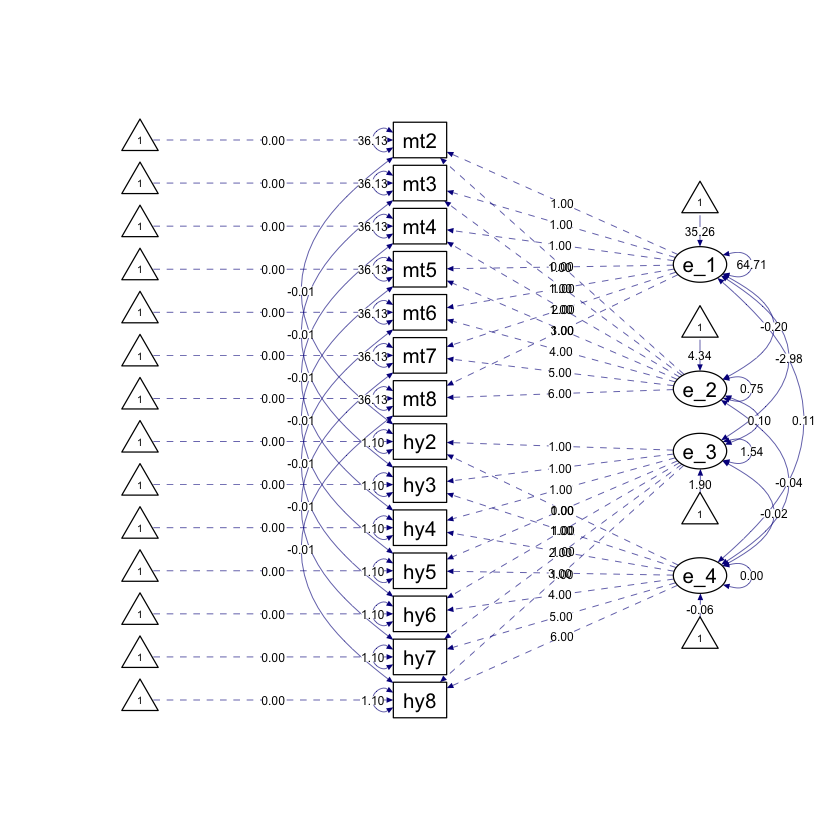

In [9]:
bivariate_lavaan_fit |>
semPaths(
    style = "ram",
    whatLabels = "par", edge.label.cex = .6, 
    label.prop = 0.9, edge.label.color = "black", rotation = 4,
    equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
    edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
    shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
    curve = 2, unCol = "#070b8c"
)

Nell'analisi condotta, abbiamo ottenuto risultati significativi riguardo alle relazioni tra diverse variabili. In particolare:

1. La covarianza tra le intercette dei punteggi in matematica (`eta_1`) e i livelli di iperattività (`eta_3`) nella seconda elementare è risultata significativa e negativa (-2.979). Ciò suggerisce che i bambini con punteggi attesi più bassi in matematica nella seconda elementare tendevano ad avere livelli attesi più alti di iperattività nella seconda elementare.

2. Tuttavia, la covarianza tra l'intercetta per i punteggi in matematica (`eta_1`) e la pendenza (tasso di cambiamento) per l'iperattività (`eta_4`) tra la seconda e l'ottava elementare non è risultata significativa (0.11). Ciò indica che i punteggi attesi in matematica di un bambino nella seconda elementare non erano associati al loro tasso atteso di cambiamento nell'iperattività negli anni successivi.

3. Allo stesso modo, la covarianza tra l'intercetta per l'iperattività (`eta_2`) e la pendenza per la matematica (`eta_3`) non è risultata significativa (0.098). Ciò implica che il livello atteso di iperattività di un bambino nella seconda elementare non era correlato al loro tasso atteso di cambiamento nei punteggi in matematica dalla seconda all'ottava elementare.

4. Inoltre, la covarianza tra la pendenza per la matematica (`eta_2`) e la pendenza per l'iperattività (`eta_4`) non è risultata significativa (-0.040). Ciò significa che il tasso atteso di cambiamento nei punteggi in matematica di un bambino non era correlato al loro tasso atteso di cambiamento nei punteggi di iperattività nel corso del periodo osservato.

5. Infine, la covarianza tra i residui (variazioni non spiegate) per la matematica (`.math2`) e l'iperattività (`.hyp2`) non è risultata significativa (-0.011). Ciò indica che non c'era un'associazione rilevabile tra matematica e iperattività oltre a quanto poteva essere spiegato dalle associazioni tra i loro processi di crescita.

In sintesi, questi risultati mettono in evidenza le relazioni tra i punteggi in matematica e i livelli di iperattività in diverse fasi dello sviluppo, suggerendo che le prestazioni in matematica precoci potrebbero essere legate ai livelli iniziali di iperattività, ma non necessariamente ai cambiamenti nell'iperattività o nei punteggi in matematica nel tempo.

## Modello di Crescita con Covariata Variabile nel Tempo

Per semplicità, consideriamo un modello di crescita *univariato* con una covariata variabile nel tempo. In particolare, esamineremo la variazione lineare delle abilità matematiche in funzione della stagione dell'anno scolastico. La variabile di interesse è rappresentata dalle abilità matematiche, misurate in un intervallo di tempo. La covariata `spring` è rappresentata dalla stagione dell'anno scolastico, che è una variabile dicotomica che indica se la misurazione è stata effettuata in autunno o primavera.

Importiamo i dati.

In [10]:
# Set filepath
filepath <- "https://quantdev.ssri.psu.edu/sites/qdev/files/nlsy_math_hyp_long.csv"
# Read in the .csv file using the url() function
nlsy_math_hyp_long <- read.csv(file = url(filepath), header = TRUE)

math <- data.frame(
    id = nlsy_math_hyp_long$id,
    var = nlsy_math_hyp_long$math,
    grade = nlsy_math_hyp_long$grade,
    d_math = 1,
    d_hyp = 0,
    grp = "math"
)

hyp <- data.frame(
    id = nlsy_math_hyp_long$id,
    var = nlsy_math_hyp_long$hyp,
    grade = nlsy_math_hyp_long$grade,
    d_math = 0,
    d_hyp = 1,
    grp = "hyp"
)

multivariate <- rbind(math, hyp)

nlsy_math_long_math <- data.frame(cbind(
    nlsy_math_hyp_long$id,
    nlsy_math_hyp_long$grade,
    nlsy_math_hyp_long$math
))
names(nlsy_math_long_math) <- c(
    "id",
    "grade",
    "math"
)

nlsy_math_long_hyp <- data.frame(cbind(
    nlsy_math_hyp_long$id,
    nlsy_math_hyp_long$grade,
    nlsy_math_hyp_long$hyp
))
names(nlsy_math_long_hyp) <- c(
    "id",
    "grade",
    "hyp"
)

math_wide <- nlsy_math_long_math %>% spread(grade, math)
# give name to the variables with the grade
names(math_wide) <- c("id", "math.2", "math.3", "math.4", "math.5", "math.6", "math.7", "math.8")

hyp_wide <- nlsy_math_long_hyp %>% spread(grade, hyp)
# give name to the variables with the grade
names(hyp_wide) <- c("id", "hyp.2", "hyp.3", "hyp.4", "hyp.5", "hyp.6", "hyp.7", "hyp.8")

short <- merge(math_wide, hyp_wide, by = "id")

nlsy_math_long_spring <- data.frame(cbind(
    nlsy_math_hyp_long$id,
    nlsy_math_hyp_long$grade,
    nlsy_math_hyp_long$spring
))

names(nlsy_math_long_spring) <- c(
    "id",
    "grade",
    "spring"
)

spring_wide <- nlsy_math_long_spring %>% spread(grade, spring)
names(spring_wide) <- c("id", "spring.2", "spring.3", "spring.4", "spring.5", "spring.6", "spring.7", "spring.8")

math.spring <- merge(math_wide, spring_wide, by = "id")
head(math.spring)

,id,math.2,math.3,math.4,math.5,math.6,math.7,math.8,spring.2,spring.3,spring.4,spring.5,spring.6,spring.7,spring.8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,NA,38,NA,55,NA,NA,NA,NA,1,NA,1,NA,NA,NA
2,303,26,NA,NA,33,NA,NA,NA,1,NA,NA,1,NA,NA,NA
3,2702,56,NA,58,NA,NA,NA,80,1,NA,1,NA,NA,NA,1
4,4303,NA,41,58,NA,NA,NA,NA,NA,0,1,NA,NA,NA,NA
5,5002,NA,NA,46,NA,54,NA,66,NA,NA,1,NA,0,NA,1
6,5005,35,NA,50,NA,60,NA,59,0,NA,1,NA,1,NA,1



Il modello di crescita può essere espresso come segue:

In [11]:
univariate_time_varying_model <- "
    # factor loadings
    b0m =~ 1* math.2
    b0m =~ 1* math.3
    b0m =~ 1* math.4
    b0m =~ 1* math.5
    b0m =~ 1* math.6
    b0m =~ 1* math.7
    b0m =~ 1* math.8

    b1m =~ 0* math.2
    b1m =~ 1* math.3
    b1m =~ 2* math.4
    b1m =~ 3* math.5
    b1m =~ 4* math.6
    b1m =~ 5* math.7
    b1m =~ 6* math.8

    # factor means
    b0m ~ start(35)*1 # with a starting value at 35
    b1m ~ start(4)*1  # with a starting value at 4

    # means of the observed variables (fixed at zero)
    math.2 ~ 0
    math.3 ~ 0
    math.4 ~ 0
    math.5 ~ 0
    math.6 ~ 0
    math.7 ~ 0
    math.8 ~ 0

    # observed variables regressed on the time-varying covariate
    math.2 ~ a * spring.2
    math.3 ~ a * spring.3
    math.4 ~ a * spring.4
    math.5 ~ a * spring.5
    math.6 ~ a * spring.6
    math.7 ~ a * spring.7
    math.8 ~ a * spring.8

    spring.2 ~ 1
    spring.3 ~ 1
    spring.4 ~ 1
    spring.5 ~ 1
    spring.6 ~ 1
    spring.7 ~ 1
    spring.8 ~ 1

    # factor variances
    b0m ~~ b0m
    b1m ~~ b1m

    # covariances between factors
    b0m ~~ b1m

    # variances of observed variables (made equivalent by naming theta1)
    math.2 ~~ theta1*math.2
    math.3 ~~ theta1*math.3
    math.4 ~~ theta1*math.4
    math.5 ~~ theta1*math.5
    math.6 ~~ theta1*math.6
    math.7 ~~ theta1*math.7
    math.8 ~~ theta1*math.8

    spring.2 ~~ theta2 * spring.2
    spring.3 ~~ theta2 * spring.3
    spring.4 ~~ theta2 * spring.4
    spring.5 ~~ theta2 * spring.5
    spring.6 ~~ theta2 * spring.6
    spring.7 ~~ theta2 * spring.7
    spring.8 ~~ theta2 * spring.8
"

In [12]:
fit_time_varying <- sem(univariate_time_varying_model,
    data = math.spring,
    missing = "fiml",
    estimator = "ml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


In [13]:
summary(fit_time_varying) |>
    print()

lavaan 0.6.17 ended normally after 81 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        33
  Number of equality constraints                    18

  Number of observations                           932
  Number of missing patterns                        60

Model Test User Model:
                                                      
  Test statistic                              1227.519
  Degrees of freedom                               104
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Observed
  Observed information based on                Hessian

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)
  b0m =~                                              
    math.2            1.000                           
   

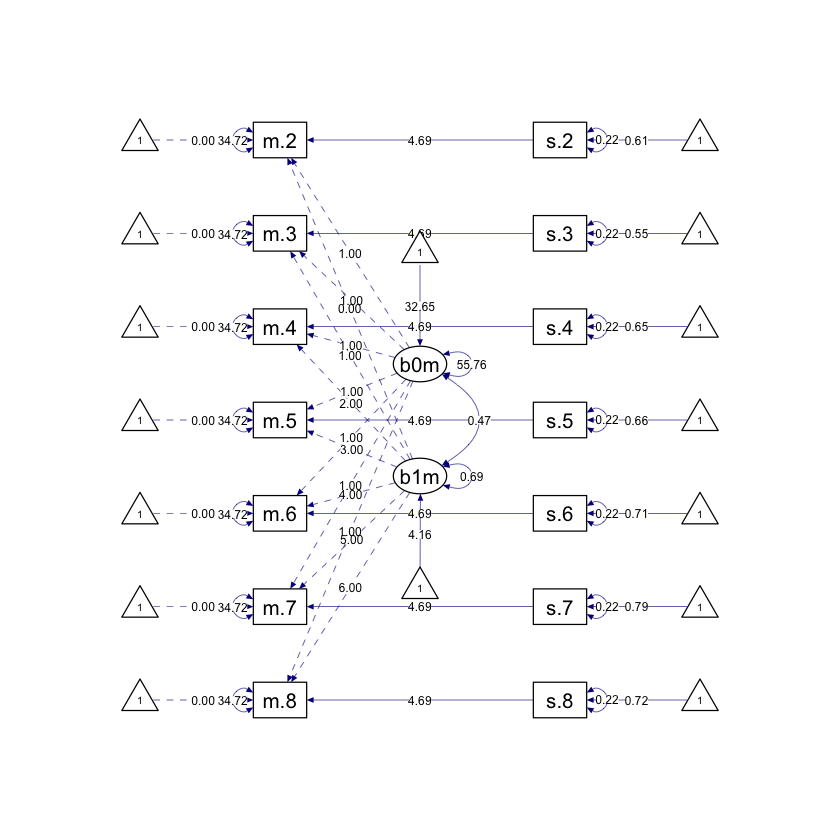

In [14]:
fit_time_varying |>
    semPaths(
        style = "ram",
        whatLabels = "par", edge.label.cex = .6, 
        label.prop = 0.9, edge.label.color = "black", rotation = 4,
        equalizeManifests = FALSE, optimizeLatRes = TRUE, node.width = 1.5,
        edge.width = 0.5, shapeMan = "rectangle", shapeLat = "ellipse",
        shapeInt = "triangle", sizeMan = 4, sizeInt = 2, sizeLat = 4,
        curve = 2, unCol = "#070b8c"
    )

In base ai risultati prodotti da `lavaan`, la covariata variabile nel tempo `spring` ha un effetto significativo sulle misurazioni delle abilità matematiche. In particolare, le abilità matematiche sono significativamente più alte in primavera rispetto all'autunno. Questo risultato è confermato dal coefficiente stimato per il modello di regressione, che è pari a 4.694. Questo coefficiente indica che, per ogni unità di aumento di `spring`, le abilità matematiche aumentano di 4.694 punti. Dato che `spring` è codificato con 0 (autunno) e 1 (primavera), il risultato indica che le abilità matematiche dei bambini sono di 4.7 punti più alte se la misurazione viene fatta nel semestre primaverile.

## Conclusione

I modelli di crescita bivariata e i modelli time-varying covariate (TVC) sono due modelli longitudinali bivariati ampiamente utilizzati in psicologia e nelle scienze sociali. Sono spesso utilizzati perché possono rispondere a domande specifiche sui processi di sviluppo e sono relativamente facili da stimare. Tuttavia, i due modelli forniscono concettualizzazioni diverse della relazione tra due o più costrutti e possono essere utilizzati per scopi diversi.

Il modello di crescita bivariata concettualizza due costrutti come processi di sviluppo in corso. Le associazioni tra i costrutti in questo modello sono associazioni tra persone, il che significa che esaminano se gli individui che cambiano in modo più positivo in un costrutto tendono a cambiare in modo più positivo anche nell'altro costrutto e viceversa.

In particolare, il modello di crescita bivariata stima i seguenti parametri:

- L'intercetta: il valore iniziale del costrutto
- La pendenza: la velocità di cambiamento del costrutto nel tempo
- La varianza: la variabilità del costrutto tra le persone
- La covarianza: la relazione tra le due variabili

Il modello TVC, invece, non assume necessariamente che la variabile nel tempo abbia un processo di cambiamento sottostante. L'effetto della variabile nel tempo è un effetto entro-persona, il che significa che modifica la traiettoria di cambiamento di un individuo. L'effetto della variabile nel tempo ha anche un effetto istantaneo sulla traiettoria, il che significa che non persiste o non influisce sui punteggi alle successive occasioni.

In particolare, il modello TVC stima i seguenti parametri:

- L'effetto della variabile nel tempo sull'intercetta: il modo in cui la variabile nel tempo influenza il valore iniziale del costrutto.
- L'effetto della variabile nel tempo sulla pendenza: il modo in cui la variabile nel tempo influenza la velocità di cambiamento del costrutto.

Il modello di crescita bivariata è il più adatto quando si ritiene che entrambi i costrutti siano soggetti a cambiamenti di sviluppo mentre il modello TVC è il più adatto quando si ritiene che uno dei costrutti sia stabile e l'altro sia influenzato da fattori esterni.

In sintesi, i modelli di crescita bivariata e i modelli TVC sono due strumenti utili per studiare la relazione tra due costrutti nel tempo. Tuttavia, è importante scegliere il modello corretto per lo scopo della propria ricerca.